# CptS 481 - Python Software Construction

## Unit 18: Embedding and Extending Python

In [2]:
# Note: Because this unit involves compilation, some of these steps are Linux-specific.
#    They may or may not work on Windows or MacOS.

try:
    from dot_figure import dotFigure
except:
    print("Unable to import 'dot_figure'. Is it installed?")
    quit()
#"<style>.container { width:100% !important; }</style>")
from IPython.display import HTML
HTML(open("../include/notes.css", "r").read())

### Embedding Python

To "embed" Python means to access Python from within another program, in this case a C program. To do this, the C program has to follow certain rules. For starters:

* ``#include`` the header file ``<Python.h>``

* call ``Py_Initialize()`` before invoking Python.

* call ``Py_Finalize()`` when you're done with the interpreter.

Incidentally, all this works in C++ with appropriate "``extern "C" { ... };``" wrappers, but we'll assume C for the rest of this unit.

#### A Simple Embedding

We'll use the ``time`` module.

In [3]:
from time import time, ctime

Here are a couple demos:

In [4]:
time()

1606853044.8853939

In [5]:
ctime(time())

'Tue Dec  1 12:04:04 2020'

Here's a small C program that embeds Python:

In [6]:
%%file demos/d0_embed_print_time/print_time.c
#include <Python.h>  // <-- this is required

int main(int argc, char *argv[])
{
    Py_Initialize();
    PyRun_SimpleString(
            "from time import time, ctime\n"
            "print('Today is', ctime(time()))\n");
    Py_Finalize();
    return 0;
}

Overwriting demos/d0_embed_print_time/print_time.c


``PyRun_SimpleString()`` does what its name suggests: Invokes the Python interpreter on any C string.

Here's a makefile for this code:

In [7]:
%%file demos/d0_embed_print_time/Makefile
PYTHON_VERSION_SUFFIX=3.8

PROGRAM_NAME = print_time

CFLAGS = \
	-g \
	-Wall \
	-Wstrict-prototypes \
	$(INCFLAGS)

INCFLAGS = \
	-I/usr/include/python$(PYTHON_VERSION_SUFFIX)

LIBFLAGS = \
	-lpython$(PYTHON_VERSION_SUFFIX)

default: $(PROGRAM_NAME)

$(PROGRAM_NAME): print_time.c
	$(CC) $(CFLAGS) $< $(LIBFLAGS) -o $@

clean:
	rm -rf *~ __pycache__ a.out *.o

immaculate: clean
	rm -rf $(PROGRAM_NAME)

Overwriting demos/d0_embed_print_time/Makefile


Let's compile and run this:

In [8]:
%%sh
cd demos/d0_embed_print_time
make immaculate # clean up previous make results
make

rm -rf *~ __pycache__ a.out *.o
rm -rf print_time
cc -g -Wall -Wstrict-prototypes -I/usr/include/python3.8 print_time.c -lpython3.8 -o print_time


Let's look at the compile and link flags:

* "``-g -Wall -Wstrict-prototypes``" -- the usual good choices for C compile flags

* "``-I``*directory*" -- the directory containing "``Python.h``" (the "``3.8``" suffix will vary with Python version)

* "``-lpython3.8``" -- the library to use (``/usr/lib/x86_64-linux-gnu/libpython3.8.so`` on a Linux system). The Python version should be the same as for the "``-I``" flag.

* "``-o print_time``" -- the binary (linked) file

Then we're ready to run the file:

In [9]:
!cd demos/d0_embed_print_time; ./print_time

Today is Tue Dec  1 12:04:07 2020


Easy, huh? Part of that is because we're not passing data between Python and C. That makes things a bit more complicated.

#### Passing Data Between C and Python (Embedded Python)

To pass data between your C program and Python requires you to call several Python library functions to convert C data to Python data and vice versa. Here's a C function that imports a module and calls any function in it that accepts and returns C doubles.

In [10]:
%%file demos/d1_embed_call_double_func/call_double_func.c
#include <stdlib.h>
#include <Python.h>

int main(int argc, char *argv[])
{
    PyObject *pName, *pModule, *pFunc;
    PyObject *pArgs, *pValue;
    int i;

    if (argc < 3) {
        fprintf(stderr, "Usage: %s moduleName functionName [arg]*\n", argv[0]);
        return 1;
    }

    Py_Initialize();
    pName = PyUnicode_FromString(argv[1]);
    /* Error checking of pName left out */

    pModule = PyImport_Import(pName);
    Py_DECREF(pName);

    if (pModule != NULL) {
        pFunc = PyObject_GetAttrString(pModule, argv[2]);
        /* pFunc is a new reference to the function we want to call. Notice
         * how it's an attribute of the module.*/

        if (pFunc && PyCallable_Check(pFunc)) {
            pArgs = PyTuple_New(argc - 3);
            /* Set up arguments in pArgs */
            for (i = 0; i < argc - 3; ++i) {
                pValue = PyFloat_FromDouble(atof(argv[i + 3]));
                if (!pValue) {
                    Py_DECREF(pArgs);
                    Py_DECREF(pModule);
                    fprintf(stderr, "Cannot convert argument\n");
                    return 1;
                }
                /* pValue reference stolen here: */
                PyTuple_SetItem(pArgs, i, pValue);
            }
            pValue = PyObject_CallObject(pFunc, pArgs);
            Py_DECREF(pArgs);
            if (pValue != NULL) {
                printf("Result of call: %g\n", PyFloat_AsDouble(pValue));
                Py_DECREF(pValue);
            } else {
                Py_DECREF(pFunc);
                Py_DECREF(pModule);
                PyErr_Print();
                fprintf(stderr,"Call failed\n");
                return 1;
            }
        } else {
            if (PyErr_Occurred())
                PyErr_Print();
            fprintf(stderr, "Cannot find function \"%s\"\n", argv[2]);
        }
        Py_XDECREF(pFunc);
        Py_DECREF(pModule); 
    } else {
        PyErr_Print();
        fprintf(stderr, "Failed to load \"%s\"\n", argv[1]);
        return 1;
    }
    Py_Finalize();
    return 0;
}

Overwriting demos/d1_embed_call_double_func/call_double_func.c


All Python objects -- modules, functions, scalars, lists, tuples, etc. -- are ``PyObject`` pointers in C, reflecting Python's polymorphism. It's pythonic to use a naming convention to keep track of these classes.

Pay special attention to the ``Py_DECREF()`` macros (that's what they are). Remember that Python uses reference counting for garbage collection. When you invoke the Python library from C, you have to maintain reference counts yourself by passing ``PyObject`` pointers to it when they're no longer in use. 
By analogy to C, think of every "``Py*``()" function that returns a "``PyObject *``" (which is most of them) as if it were a ``malloc(3)`` call and treat ``Py_DECREF()`` as if it were a ``free(3)`` call, so every "malloc" is matched with one and only one "free".

Calling ``Py_DECREF()`` is couth, but not required for your program to work. If your program runs for a long time, memory leaks are possible if you don't.

Use ``Py_XDECREF()`` if it's possible that the pointer may be ``NULL`` (in which case, the macro does nothing).

Let's compile and link the program. The makefile is the same as for ``d0_embed_print_time``, except for changing the ``PROGRAM_NAME`` macro to ``call_double_func``.

In [11]:
%%sh
cd demos/d1_embed_call_double_func
make immaculate # make from scratch for this demo
make call_double_func

rm -rf *~ __pycache__ a.out *.o
rm -rf call_double_func
cc -g -Wall -Wstrict-prototypes -I/usr/include/python3.8 call_double_func.c -lpython3.8 -o call_double_func


Here are a couple demos invoking functions in the ``math`` module:

In [12]:
!cd demos/d1_embed_call_double_func; ./call_double_func math sin 3.14159

Result of call: 2.65359e-06


In [13]:
!cd demos/d1_embed_call_double_func; ./call_double_func math atan2 1 1

Result of call: 0.785398


In [14]:
!cd demos/d1_embed_call_double_func; ./call_double_func random random

Result of call: 0.926466


That's the basics of calling Python from a C program. You can use this to use Python as a *application language*: users write little (usually) Python modules to customize big (usually) non-Python code. *Blender*, the extensive animation package, for instance, uses this.

### Extending Python

Perhaps more useful than embedding Python, invoking Python from another language, is *extending* Python: adding functionality written in another language to Python. This is how, for instance, you can write a Python API for a non-Python library.

#### A Simple Extension

Here's a a simple C extension that we'll turn into a Python module:

In [15]:
%%file demos/d2_extend_hello/hello.c
#include <Python.h>
#include <stdio.h>

static struct PyModuleDef thisModule = {
   PyModuleDef_HEAD_INIT, /* required */
   .m_name = "hello",  /* name of module */
   .m_doc = NULL,      /* module documentation, may be NULL */

    /* size of per-interpreter state of the module, or -1 if the module keeps state in global variables. */
   .m_size = -1,

   .m_methods = NULL   /* table of methods, if any */
};


PyMODINIT_FUNC PyInit_hello(void)
{
    PyObject *module = PyModule_Create(&thisModule);
    printf("Hello, Python World!\n");
    return module;
}

Overwriting demos/d2_extend_hello/hello.c


This is the bare minimum required to call C code from Python: a ``PyModuleDef`` struct and a ``PyMODINIT_FUNC`` (that's a ``typedef``) function whose name is ``PyInit_``*moduleName* which returns a module it creates.

We could invoke the C compiler directly, but ``setuptools`` makes building C extensions easy. Here's the ``setup.py`` we'll use:|

In [16]:
%%file demos/d2_extend_hello/setup.py
from setuptools import setup
from setuptools.extension import Extension # note: new class imported

setup(name='hello', # the module name
      version='1.0',
      author='Bob Lewis',
      author_email='bobl@wsu.edu',
      ext_modules=[ # a list of all extension modules in the package
          Extension('hello', # the extension module name
             [ # a list of the C source files in the extension
                'hello.c'
             ]),
        ]
    )

Overwriting demos/d2_extend_hello/setup.py


For demo purposes here, let's clean out and start from scratch: 

In [17]:
!cd demos/d2_extend_hello; python3 setup.py clean --all

running clean
removing 'build/temp.linux-x86_64-3.8' (and everything under it)
removing 'build/lib.linux-x86_64-3.8' (and everything under it)
removing 'build/bdist.linux-x86_64' (and everything under it)
'build/scripts-3.8' does not exist -- can't clean it
removing 'build'


Then we invoke ``setuptools`` just as we would for a module in Python:

In [18]:
!cd demos/d2_extend_hello; python3 setup.py build install --user

running build
running build_ext
building 'hello' extension
creating build
creating build/temp.linux-x86_64-3.8
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -Wall -Wstrict-prototypes -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c hello.c -o build/temp.linux-x86_64-3.8/hello.o
creating build/lib.linux-x86_64-3.8
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -g -g -Wall -Wstrict-prototypes -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.8/hello.o -o build/lib.linux-x86_64-3.8/hello.cpython-38-x86_64-linux-gnu.so
running install
running bdist_egg
running egg_info
writing hello.egg-info/PKG-INFO
writing dependency_links to hello.egg-info/dependency_links.txt
writing top-level names to hello.egg-info/top_level.txt
reading manifest file 'hello.egg-info/SOURCES.t

Take a look at all the flags passed to the C compiler! What do they do?

Some of them (e.g. "-g") are obvious, but not all of them. The ``setuptools`` folks chose them for presumably good reasons and there's probably some way to override them if you or I run into problems or think of something better.

Anyway, the module is now installed.

Now, pay close attention. We can *now* ``import`` the module as if it were a module written in Python!

In [19]:
%%sh
python3 <<EOF
import hello
EOF

Hello, Python World!


Note: We need to run Python as a subprocess here to override the Python interpreter Jupyter Notebook's optimization of the ``import``.

If you recall (and you probably won't) long, long ago (about 2.5 months) I said that a "``.so``" file can be a Python module. Now you know what I was talking about. On Windows, the same thing applies to a "``*.dll``" file. MacOS uses "``*.dylib``" files, but also understands "``.so``" for Python modules. We'll use "``*.so``" for the rest of this notebook.

It's hard to tell the difference between a Python module written in Python and one written in C from within your program. That's intentional.

#### Passing Data Between C and Python (Extended Python)

All of ``hello``'s C functionality is in ``PyInit_hello()``, and this will only be invoked the first time the module is ``import``ed. This makes it great for one-time initialization of global data structures, but you really want to add functions that can be called an arbitrary number of times.

Also, as with embedding, we usually need to transfer data between the Python and C parts.

So let's create a module that, in C, sums the elements of a ``list`` that's passed to it:

In [20]:
%%file demos/d3_extend_sumlist/sumlist.c
#include <Python.h>


// the "sum" function of the sumlist package
static PyObject *sumlist_sum(PyObject *self, PyObject *arg)
{
    int i, len, sum;
    PyObject *poLst;

    // extract the list argument from the tuple that is arg
    if (!PyArg_ParseTuple(arg, "O", &poLst))
        return NULL;
    // make sure poLst is a list
    if (!PyList_Check(poLst))
        return NULL;

    // sum the (integer) elements in the list
    len = PyList_Size(poLst);
    sum = 0;
    for (i = 0; i < len; i++) {
        PyObject *poElem = PyList_GetItem(poLst, i);

        sum += PyLong_AsLong(poElem);
    }

    // return the result as a python int object
    return Py_BuildValue("l", sum);
}


static struct PyMethodDef sumlist_methods[] = {
    // name      function        how arguments are passed
    { "sum",     sumlist_sum,    METH_VARARGS },
    { NULL, NULL }
};


static struct PyModuleDef thisModule = {
   PyModuleDef_HEAD_INIT,
   .m_name = "sumlist",  /* name of module */
   .m_doc = "sum a list of integers",     /* module docstring, may be NULL */
   .m_size = -1,       /* size of per-interpreter state of the module,
                or -1 if the module keeps state in global variables. */
   sumlist_methods  /* table of methods, if any */
};


PyMODINIT_FUNC PyInit_sumlist(void)
{
    return PyModule_Create(&thisModule);
}

Overwriting demos/d3_extend_sumlist/sumlist.c


A few things to notice here:

* The array ``PyMethodDef[]`` now contains a method named ``sum()``.

* We added a what will become a docstring.

* The C implementation of ``sum()`` is ```sumlist_sum()``, which takes two arguments:

   * ``self`` -- the module it's defined in

   * ``arg`` -- a ``tuple`` containing all arguments being passed

* ``sumlist_sum()`` extracts its arguments from ``arg`` using ``PyArg_ParseTuple()``, whose second argument describes the single object ("``O``") the tuple contains.

* ``PyList_Check()`` verifies that it's a list. If not, ``sumlist_sum()`` returns a ``NULL``, which will raise an exception in the Python caller. (Of course, you can customize this.)

* You can figure out what most Python C functions from the naming pattern ``Py``*PythonType*``_``*functionality*``()``.

* ``Py_BuildValue()`` is a convenient way to create basic Python structs. Resembling ``printf()``, the first argument is a string of one or more formats giving the mapping between the remaining arguments and the Python object being returned. Here is a table of the characters that control the map:

|format|C type          |Python           |
|:----:|:---------------|:----------------|
|`x`   |`pad byte`      |`no value`       |
|`c`   |`char`          |`length-1 string`|
|`b`   |`signed char`   |`int`            |
|`B`   |`unsigned char` |`int`            |
|`h`   |`short`         |`int`            |
|`H`   |`unsigned short`|`int`            |
|`i`   |`int`           |`int`            |
|`I`   |`unsigned int`  |`int`            |
|`l`   |`long`          |`int`            |
|`L`   |`unsigned long` |`int`            |
|`f`   |`float`         |`float`          |
|`d`   |`double`        |`float`         |
|`s`   |`char []`       |`string`         |
|`p`   |`char []`       |`string`         |
|`P`   |`void *`        |`integer`        |

Again, for demo purposes here, we clean out the automatically-generated files.

In [21]:
!cd demos/d3_extend_sumlist; python3 setup.py clean --all

running clean
removing 'build/temp.linux-x86_64-3.8' (and everything under it)
removing 'build/lib.linux-x86_64-3.8' (and everything under it)
removing 'build/bdist.linux-x86_64' (and everything under it)
'build/scripts-3.8' does not exist -- can't clean it
removing 'build'


Then we compile and link it as for ``d2_extend_hello``:

In [22]:
!cd demos/d3_extend_sumlist; python3 setup.py build install --user

running build
running build_ext
building 'sumlist' extension
creating build
creating build/temp.linux-x86_64-3.8
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -Wall -Wstrict-prototypes -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c sumlist.c -o build/temp.linux-x86_64-3.8/sumlist.o
creating build/lib.linux-x86_64-3.8
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -g -g -Wall -Wstrict-prototypes -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.8/sumlist.o -o build/lib.linux-x86_64-3.8/sumlist.cpython-38-x86_64-linux-gnu.so
running install
running bdist_egg
running egg_info
writing sumlist.egg-info/PKG-INFO
writing dependency_links to sumlist.egg-info/dependency_links.txt
writing top-level names to sumlist.egg-info/top_level.txt
reading manifest file 'sumlist.

Now we can call the C function from Python as many times as we like:

In [23]:
%%sh
cd demos
python3 <<EOF
import sumlist

for nDigits in range(0, 6):
    upperLimit = 10**nDigits
    lst = list(range(1, upperLimit+1))
    print('sum of values from 1 to {}, inclusive...'.format(upperLimit))
    print(f'in Python: {sum(lst):,}')
    print(f'     in C: {sumlist.sum(lst):,}')
    print()
EOF

sum of values from 1 to 1, inclusive...
in Python: 1
     in C: 1

sum of values from 1 to 10, inclusive...
in Python: 55
     in C: 55

sum of values from 1 to 100, inclusive...
in Python: 5,050
     in C: 5,050

sum of values from 1 to 1000, inclusive...
in Python: 500,500
     in C: 500,500

sum of values from 1 to 10000, inclusive...
in Python: 50,005,000
     in C: 50,005,000

sum of values from 1 to 100000, inclusive...
in Python: 5,000,050,000
     in C: 705,082,704



Why are the last two results different? Which one is right? What went wrong with the other?

Our docstring works identically to one created in a Python module:

In [24]:
!pydoc3 sumlist

Help on module sumlist:

NNAAMMEE
    sumlist - sum a list of integers

FFUUNNCCTTIIOONNSS
    ssuumm(...)

FFIILLEE
    /home/bobl/.local/lib/python3.8/site-packages/sumlist-1.0-py3.8-linux-x86_64.egg/sumlist.cpython-38-x86_64-linux-gnu.so




Step back and realize what you can do now: Given any C (library) code, you can write a Python interface for it.

#### Debugging Your Extension

We've talked about ``pdb`` to debug Python, but how can we debug a C extension?

For the true Python/C aficionado, the following will look amazing at first, but obvious upon reflection.

*This won't work in* Jupyter Notebook *. To try it for yourself -- recommended -- start the* gdb *session in a separate terminal window in the ``demos/d3_extend_sumlist`` subdirectory.*

Yes, you are now running *gdb* on the Python interpreter and it has stopped at a breakpoint you set **within your C extension**. You've now got the full functionality of *gdb* to debug your extension. (Well, *I* find it mind boggling!)

The result of the ``where`` command (the calling stack) is interesting, although not all that useful unless you have Python source compiled with debugging.

#### Flashback: Distributing C-Based Python Modules

Now that we understand how to turn C code into a Python module (and, if needed, have debugged it), how can we distribute it? That's easy: using``setuptools`` again just as we did before.

The directory hierarchy resulting from the ``build`` command is:

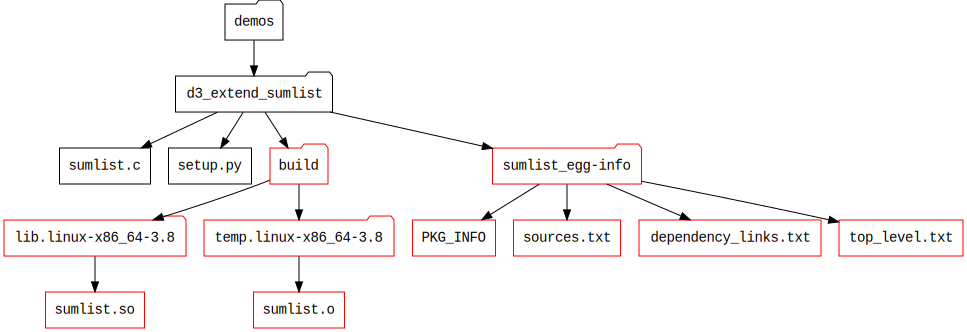

In [25]:
dotFigure("figures/g00_after_build.gv")

and after "``build bdist``", we get an "egg" file.

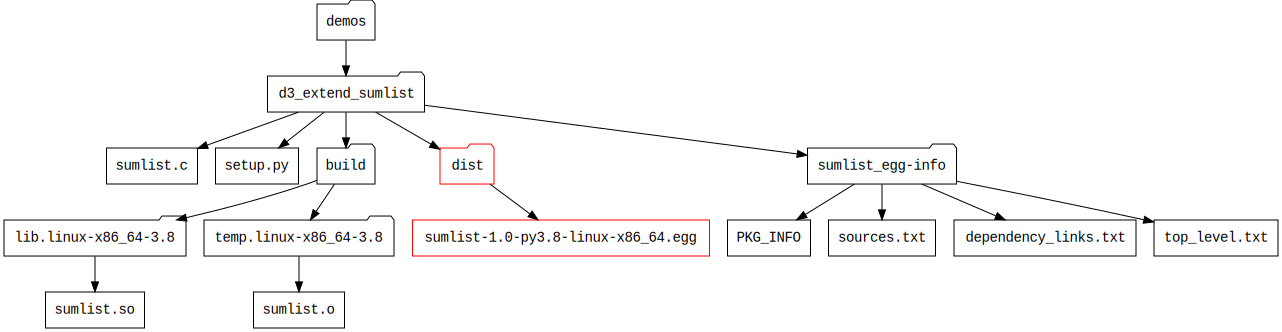

In [26]:
dotFigure("figures/g01_after_build_bdist.gv")

Again, red indicates files and directories added by ``setuptools`` if necessary during the bdist build.

Notice that the ``lib``-prefixed directory name now takes account of the build architecture and the Python version (i.e. ``Python.h`` and Python library) we're compiling for.

Let's try a dry run of the ``install`` command:

In [30]:
!cd demos/d3_extend_sumlist; python3 setup.py install --user --dry-run

running install
running bdist_egg
running egg_info
writing sumlist.egg-info/PKG-INFO
writing dependency_links to sumlist.egg-info/dependency_links.txt
writing top-level names to sumlist.egg-info/top_level.txt
reading manifest file 'sumlist.egg-info/SOURCES.txt'
writing manifest file 'sumlist.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
creating build/bdist.linux-x86_64/egg
copying build/lib.linux-x86_64-3.8/sumlist.cpython-38-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg
creating stub loader for sumlist.cpython-38-x86_64-linux-gnu.so
byte-compiling build/bdist.linux-x86_64/egg/sumlist.py to sumlist.cpython-38.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying sumlist.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying sumlist.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying sumlist.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying sumlist

In addtion to ``install``, everything else in the distribution process (``sdist``, ``bdist*``, etc.) work as before, copying the "``*.so``" file(s) into their install destination (e.g. ``~/.local/lib/python``*whatever*) or the ``dist`` subdirectory for subsequent packaging.

Since ``setup.py`` is included in the source ("``sdist``") distribution, anybody who installs it and runs "``python3 setup.py build``" or "``python3 setup.py install``" (with or without ``--user``) on that platform will build or install a "``*.so``" module ready for their platform, regardless of OS. This is how Python allows for portability of compiled extensions.

The ``build/temp.*`` directory is there for debugging and will go away if you run: 

In [29]:
!cd demos/d3_extend_sumlist; python3 setup.py clean

running clean
removing 'build/temp.linux-x86_64-3.8' (and everything under it)


### Automatic API Construction With ``swig``

Creating a "``*.so``" file "by hand" like this is a good strategy when you've got just a few C functions to access from Python, but let's suppose you had a larger body of code you didn't want to convert by hand, especially one that might be changing. In that case, there's *swig*: Simplified Wrapper and Interface Generator.

#### A Simple ``swig`` Example

Let's start with a simple example.

Start with a header file declaring three functions we'd like to call from Python:

In [31]:
%%file demos/d4_swig_3funcs.h
extern int fact(int n);
extern int my_mod(int x, int y);
extern char *get_time(void);

Writing demos/d4_swig_3funcs.h


Here's the C file that implements these functions:

In [32]:
%%file demos/d4_swig_three_funcs/three_funcs.c
#include <time.h>
#include "three_funcs.h"

int fact(int n)
{
    if (n <= 1)
        return 1;
    else
        return n*fact(n-1);
}

int my_mod(int n, int m)
{
    return (n % m);
}

char *get_time(void)
{
    long ltime;
    time(&ltime);
    return ctime(&ltime);
}

Overwriting demos/d4_swig_three_funcs/three_funcs.c


And here's the header file that goes with it:

In [ ]:
%%file demos/d4_swig_three_funcs/three_funcs.h
extern int fact(int n);
extern int my_mod(int x, int y);
extern char *get_time(void);

*swig* works with an interface specification file, usually with a "``*.i``" extension, that has prototypes of all the functions you wish to export to Python. If you want to import everything in the header file, you can "``%include ``" (note the "``%``") it.

In [ ]:
%%file demos/d4_swig_three_funcs/three_funcs.i
%module three_funcs

%{
/* This code goes into the wrapper and is needed for it to compile. */
#include "three_funcs.h"
%}

/*
 * Here is the specification for the functions to be exported to Python.
 * The "include" here has a different meaning beyond the "%" prefix.
 *
 *
 * The "*.i" file is not a header file: "#" won't work here. If
 * you don't want to export every declaration in the header file,
 * include only those you want here.
 */
%include "three_funcs.h"

So we start out with a directory containing these three files:

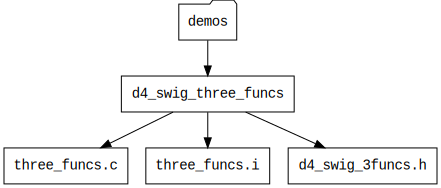

In [33]:
dotFigure("figures/g02_initial_swig.gv")

We compile the C source to an object file as usual:

In [34]:
!cd demos/d4_swig_three_funcs; make clean; make three_funcs.o

rm -rf *~ __pycache__ a.out *.o _three_funcs.so three_funcs.py three_funcs_wrap.c
cc -c -g -Wall -fPIC -Wstrict-prototypes -I/usr/include/python3.8 three_funcs.c -o three_funcs.o


But instead of converting the "``*.o``" file to a "``*.so``" file as for an extension, we run *swig*:

*You'll need to install* swig *to do this.*

In [36]:
!cd demos/d4_swig_three_funcs; swig -python -module three_funcs three_funcs.i

The directory now looks like this:

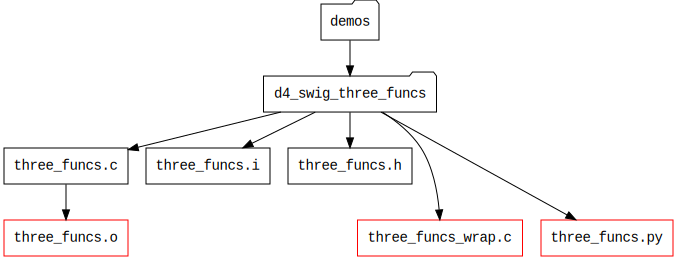

In [37]:
dotFigure("figures/g03_after_swig.gv")

Next, we compile the (pretty big, but so what?) C wrapper file:

In [38]:
!cd demos/d4_swig_three_funcs; make three_funcs_wrap.o

cc -c -g -Wall -fPIC -Wstrict-prototypes -I/usr/include/python3.8 three_funcs_wrap.c -o three_funcs_wrap.o


*Then* we create the "``*.so``" file with both the original object *and* the compiled "``*_wrap.o``" file, but we prefix the name with "``_``" because we won't import it directly. The "``*.py``" file is expecting the "``_``" and will do that.

In [39]:
!cd demos/d4_swig_three_funcs; ld -shared three_funcs.o three_funcs_wrap.o -o _three_funcs.so

And we can now access the module's functions in the usual way:

In [42]:
%%sh
cd demos/d4_swig_three_funcs
python3 <<EOF
import three_funcs
print(repr(three_funcs.get_time()))
print(three_funcs.my_mod(7, 5))
print(three_funcs.fact(10))
EOF

'Tue Dec  1 12:37:46 2020\n'
2
3628800


Interesting sidelight: If you didn't have the source, only object ("``*.so``" or "``*.o``") and header files, you could still create a "``*.i``", run *swig* on it, compile the "``*_wrap.c``", and link the result with the object files to get a functioning API for code.

In short, *swig* does not require the source code. You could wrap *somebody else's* object and header files and access them from Python. Sneaky!

TODO: Integrate these with `setuptools`.

### Accessing C Code Directly With ``ctypes``

Suppose we just want to access some existing compiled C code without building a whole API or creating a Python module to access it. That's what ``ctypes`` is for.

#### Accessing Functions

Let's start with some code that has no knowledge that it's going to be accessed from Python: 

In [43]:
%%file demos/d5_ctypes_funcs/funcs.c
/*
 * arbitrary C code (adapted from from ctypes documentation)
 *
 * Note: No special Python #includes
 */

#include <time.h>

long long fact(int n) {
// computes n!
    if (n <= 1)
        return 1;
    else
        return n * fact(n-1);
}

char *get_time(void) {
// returns a char * (C string)
    long ltime;
    time(&ltime);
    return ctime(&ltime);
}

int my_mod(int n, int m) {
// returns n mod m
    return (n % m);
}

Overwriting demos/d5_ctypes_funcs/funcs.c


Just compile it as usual and create a shared library with it:

In [44]:
%%sh
cd demos/d5_ctypes_funcs
cc -c -g -shared -Wall -Wstrict-prototypes -fPIC funcs.c
ld -shared funcs.o -o funcs.so

Here's a Python source file that uses the ``ctypes`` module:

In [45]:
%%file demos/d5_ctypes_funcs/funcs_t.py
from ctypes import CDLL, c_char_p, c_longlong

# note: You need to specify a directory, even if it's ".".
funcs = CDLL("./funcs.so") # equivalent to "import funcs"

time = funcs.get_time()
print("using default get_time() return type")
print("      get_time() return: {!r}".format(time))
print("  isinstance(time, int): {}".format(isinstance(time, int)))
print()

# We need to tell ctypes to that the get_time() result is a "char *",
# so that it will be converted to a bytes.
funcs.get_time.restype = c_char_p

print("after coercing get_time return type to \"c_char_p\" (char *)")
time = funcs.get_time()
print("      get_time() return: {}".format(time))
print("  isinstance(time, int):", isinstance(time, int))
print("isinstance(time, bytes):", isinstance(time, bytes))
print()

# We also need to tell that the return of fact() is a "long long".
funcs.fact.restype = c_longlong
for i in range(0,20):
    n = funcs.fact(i)
    print("{:>2} factorial is {:20}".format(i, n))

Overwriting demos/d5_ctypes_funcs/funcs_t.py


This is just a normal "``*.so``" file, so we can do this with any shared object.

In [46]:
!cd demos/d5_ctypes_funcs; python3 funcs_t.py

using default get_time() return type
      get_time() return: 1680514432
  isinstance(time, int): True

after coercing get_time return type to "c_char_p" (char *)
      get_time() return: b'Tue Dec  1 12:44:00 2020\n'
  isinstance(time, int): False
isinstance(time, bytes): True

 0 factorial is                    1
 1 factorial is                    1
 2 factorial is                    2
 3 factorial is                    6
 4 factorial is                   24
 5 factorial is                  120
 6 factorial is                  720
 7 factorial is                 5040
 8 factorial is                40320
 9 factorial is               362880
10 factorial is              3628800
11 factorial is             39916800
12 factorial is            479001600
13 factorial is           6227020800
14 factorial is          87178291200
15 factorial is        1307674368000
16 factorial is       20922789888000
17 factorial is      355687428096000
18 factorial is     6402373705728000
19 factorial is  

Check that last value!

``ctypes`` exports the ``cdll`` object, which is a "library loader". On Windows,
there are also ``windll`` and ``oledll`` objects, which do similar things for Windows and OLE DLL files.

The ``CDLL()`` call above is actually instancing the ``CDLL`` class. It's the same as ``cdll.LoadLibrary()``.

#### Accessing Global Data

To access (global) data from C code, start again with C source (or an "``*.so``" file whose contents you know the names and C types of):

In [47]:
%%file demos/d6_ctypes_data/data.c
/*
 *  Initialize some C global variables.
 */
float f = 42.0;
double d = -19.53;
int i = -34;
char *s = "spam";

Overwriting demos/d6_ctypes_data/data.c


Then compile and link it into a "``*.so``" file:

In [48]:
%%sh
cd demos/d6_ctypes_data
cc -c -g -shared -Wall -Wstrict-prototypes data.c
ld -shared data.o -o data.so

You can then access the data with ``ctypes`` as follows:

In [49]:
%%file demos/d6_ctypes_data/data_t.py
from ctypes import CDLL, c_float, c_double, c_int, c_char_p
data = CDLL("./data.so")

f = c_float.in_dll(data, "f")
print("f: {}".format(f.value))

d = c_double.in_dll(data, "d")
print("d: {}".format(d.value))

i = c_int.in_dll(data, "i")
print("i: {}".format(i.value))

s = c_char_p.in_dll(data, "s")
print("s: {}".format(s.value))

Overwriting demos/d6_ctypes_data/data_t.py


In [50]:
!cd demos/d6_ctypes_data; python3 data_t.py

f: 42.0
d: -19.53
i: -34
s: b'spam'
